In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings
from collections import OrderedDict

# Taylor diagram code from Joe 

In [93]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) test implementation.

http://www-pcmdi.llnl.gov/about/staff/Taylor/CV/Taylor_diagram_primer.htm
"""

__version__ = "Time-stamp: <2012-02-17 20:59:35 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT

class TaylorDiagram(object):
    """Taylor diagram: plot model standard deviation and correlation
    to reference (data) sample in a single-quadrant polar plot, with
    r=stddev and theta=arccos(correlation).
    """

    def __init__(self, refstd, fig=None, rect=111, label='_'):
        """Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using mpl_toolkits.axisartist.floating_axes. refstd is
        the reference standard deviation to be compared to.
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.concatenate((NP.arange(10)/10.,[0.95,0.99]))
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str,rlocs))))

        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.5*self.refstd

        ghelper = FA.GridHelperCurveLinear(tr,
                                           extremes=(0,NP.pi/2, # 1st quadrant
                                                     self.smin,self.smax),
                                           grid_locator1=gl1,
                                           tick_formatter1=tf1,
                                           )

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")  # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom") # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")   # "Y axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")

        ax.axis["bottom"].set_visible(False)         # Useless
        
        # Contours along standard deviations
        ax.grid(False)

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        print("Reference std:" %self.refstd)
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label='Observed')
        t = NP.linspace(0, NP.pi/2)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t,r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """Add sample (stddev,corrcoeff) to the Taylor diagram. args
        and kwargs are directly propagated to the Figure.plot
        command."""

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs) # (theta,radius)
        self.samplePoints.append(l)

        return l

    def add_contours(self, levels=5, **kwargs):
        """Add constant centered RMS difference contours."""

        rs,ts = NP.meshgrid(NP.linspace(self.smin,self.smax),
                            NP.linspace(0,NP.pi/2))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))
        
        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

load data

In [4]:
dpi = 200
workdir = os.getcwd()
monthly_filename = 'fluxes_monthly4.1978-01.nc'
daily_filename = 'fluxes_daily4.1978-01-01.nc'
domain_file = 'calm_domain_file_adj_11282016.nc'
params_ncfile = 'params_calm_sites_11282016.nc'
mo_fluxes = xr.open_dataset(os.path.join(workdir, monthly_filename))
day_fluxes = xr.open_dataset(os.path.join(workdir, daily_filename))
domain = xr.open_dataset(os.path.join(workdir, domain_file))
params = xr.open_dataset(os.path.join(workdir, params_ncfile))

put annual thaw depths from simulated runs and obs into arrays for Taylor diagram

In [5]:
sim = OrderedDict()
obs = OrderedDict()

set up data for Barrow CALM site, North Slope, Alaska (71.316667, 203.400000)

73
130


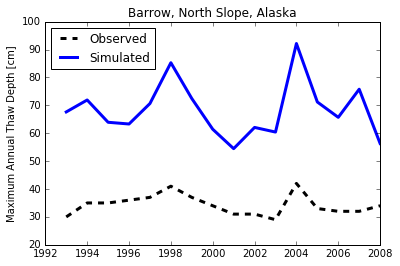

In [6]:
barrow_lat = 71.316667
barrow_lng = 203.400000
lw = 3.0

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 9):
        raise ValueError('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])

# define site thaw depths and years 

barrow_thaw_depths = [30, 35, 35, 36, 37, 41, 37, 34, 31, 31, 29, 42, 33, 32, 32, 34]
barrow_years = np.arange(1993, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1992], (annual_max_thaw_depths[vic_years > 1992] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(loc='upper left')
plt.title('Barrow, North Slope, Alaska')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

# add to dicts
sim.update({'barrow': annual_max_thaw_depths[vic_years > 1992] * 100.0})
obs.update({'barrow': barrow_thaw_depths})

plotname = 'barrow1.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

# Toolik site, North Slope, Alaska (68.617, 210.40)

64
130


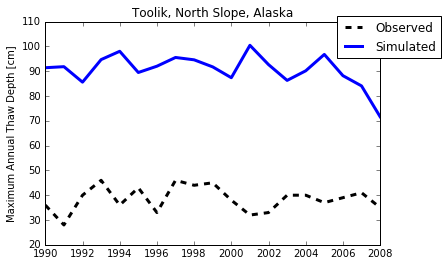

In [7]:
barrow_lat = 68.61666666666666
barrow_lng = 210.40000000000001

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 9):
        raise warning.Warning('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])
        ind_month = 8

# define site thaw depths and years 

# 40	46	36	43	33	46	44	45	38	32	33	40	40	37	39	41	35

barrow_thaw_depths = [36, 28, 40, 46, 36, 43, 33, 46, 44, 45, 38, 32, 33, 40, 40, 37, 39, 41, 35]
barrow_years = np.arange(1990, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1989], (annual_max_thaw_depths[vic_years > 1989] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(bbox_to_anchor=(1.2, 1.05), loc='upper right')
plt.title('Toolik, North Slope, Alaska')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

# add to dicts
sim.update({'toolik': annual_max_thaw_depths[vic_years > 1989] * 100.0})
obs.update({'toolik': barrow_thaw_depths})

plotname = 'toolik.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

# Happy Valley  site, North Slope, Alaska (69.167, 211.167)

65
131


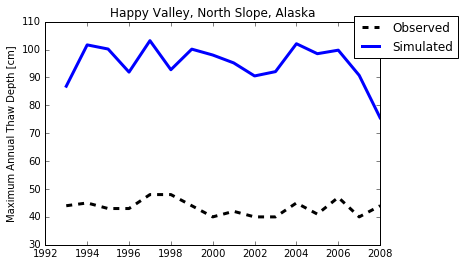

In [8]:
barrow_lat = 69.166666666666671
barrow_lng = 211.16666666666666

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 9):
        raise ValueError('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])

# define site thaw depths and years 

# 44	45	43	43	48	48	44	40	42	40	40	45	41	47	40	44

barrow_thaw_depths = [44, 45, 43, 43, 48, 48, 44, 40, 42, 40, 40, 45, 41, 47, 40, 44]
barrow_years = np.arange(1993, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1992], (annual_max_thaw_depths[vic_years > 1992] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(bbox_to_anchor=(1.25, 1.05), loc='upper right')
plt.ylim([30, 110])
plt.title('Happy Valley, North Slope, Alaska')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

# add to dicts
sim.update({'happy_valley': annual_max_thaw_depths[vic_years > 1992] * 100.0})
obs.update({'happy_valley': barrow_thaw_depths})

plotname = 'happy_valley1.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

# Wickersham site, Alaska Interior (65.267, 211.95)

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Nov
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in May


58
127


/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Dec


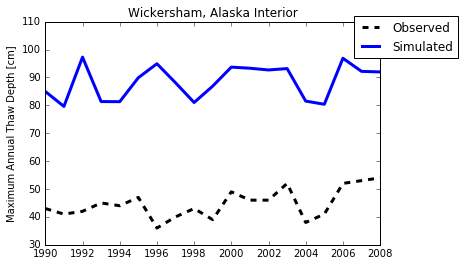

In [9]:
barrow_lat = 65.266666666666666
barrow_lng = 211.94999999999999

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 9):
        warnings.warn('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])
        ind_month = 8

# define site thaw depths and years 

# 43	41	42	45	44	47	36	40	43	39	49	46	46	52	38	41	52	53	54

barrow_thaw_depths = [43, 41, 42, 45, 44, 47, 36, 40, 43, 39, 49, 46, 46, 52, 38, 41, 52, 53, 54]
barrow_years = np.arange(1990, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1989], (annual_max_thaw_depths[vic_years > 1989] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(bbox_to_anchor=(1.25, 1.05), loc='upper right')
plt.ylim([30, 110])
plt.title('Wickersham, Alaska Interior')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

# add to dicts
sim.update({'wickersham': annual_max_thaw_depths[vic_years > 1989] * 100.0})
obs.update({'wickersham': barrow_thaw_depths})

plotname = 'wickersham.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

# Chukotka, Cape Rogozhny, R9, Russia or Siberia (64.78, 176.967)

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Nov
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Dec


83
105


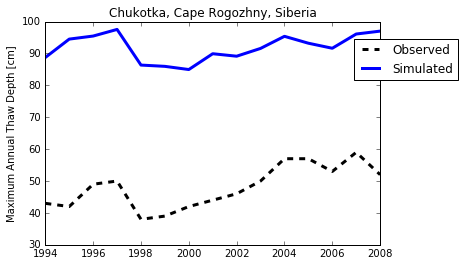

In [10]:
barrow_lat = 64.783333333333331
barrow_lng = 176.96666666666667

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 9):
        warnings.warn('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])
        ind_month = 8

# define site thaw depths and years 

# 43	42	49	50	38	39	42	44	46	50	57	57	53	59	 52

barrow_thaw_depths = [43, 42, 49, 50, 38, 39, 42, 44, 46, 50, 57, 57, 53, 59, 52]
barrow_years = np.arange(1994, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1993], (annual_max_thaw_depths[vic_years > 1993] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(bbox_to_anchor=(1.25, .95), loc='upper right')
plt.title('Chukotka, Cape Rogozhny, Siberia')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

# add to dicts
sim.update({'chukotka': annual_max_thaw_depths[vic_years > 1993] * 100.0})
obs.update({'chukotka': barrow_thaw_depths})

plotname = 'chukotka.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

# Nadym, West Siberia, R1 (64.78, 176.967)

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Feb
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Jan
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Dec
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Nov


159
151


/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Mar


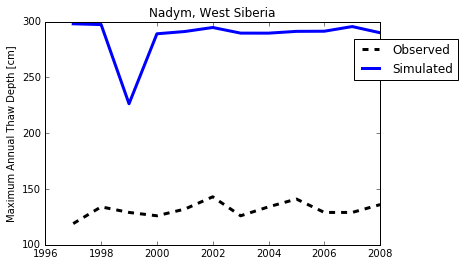

In [11]:
barrow_lat = 65.333333333333329
barrow_lng = 72.916666666666671

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 7):
        warnings.warn('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])
        ind_month = 8

# define site thaw depths and years 

# 119	134	129	126	132	143	126	134	141	129	129	136

barrow_thaw_depths = [119, 134, 129, 126, 132, 143, 126, 134, 141, 129, 129, 136]
barrow_years = np.arange(1997, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1996], (annual_max_thaw_depths[vic_years > 1996] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(bbox_to_anchor=(1.25, .95), loc='upper right')
plt.title('Nadym, West Siberia')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

plotname = 'nadym.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

# Northern Tian Shan (43.083, 76.917)

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Feb
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Mar


204
138


/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: this annual maximum thaw depth should be occurring in the summerrather than in Jan


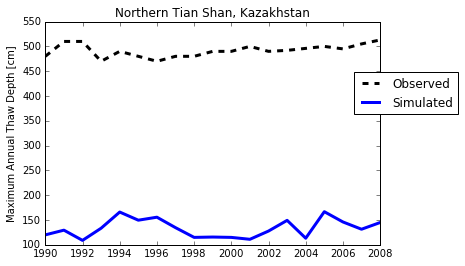

In [12]:
barrow_lat = 43.083333333333336
barrow_lng = 76.916666666666671

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
print(nj_ind)
print(ni_ind)
soil_depths = params.depth[:, nj_ind, ni_ind]

# find the max zero depths (e.g. annual maximum thaw depth) for the full time series, and this should occur 
# between June - September, so if it's not, this method raises an error  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate the midpoints of the soil layers to calculate the thermal profile of the soil layers
u = np.diff(np.insert(np.cumsum(soil_depths.values), 0, 0., axis=0)) / 2.0
v = np.cumsum(np.insert(soil_depths.values, 0, 0., axis=0))[:-1]
mid_soil_depths = u + v
colors = ['r', 'g', 'k', 'maroon', 'y', 'magenta', 'cyan', 'purple', 'chartreuse', 'indigo', 
          'limegreen', 'darkorange']

# initialize array of annual maximum thaw depths 
annual_max_thaw_depths = []

# loop over years and calculate annual maximum thaw depths 
for year in range(1978, 2009):
    year_start = '%s-01-01' % year
    year_end = '%s-12-31' %year
    # initialize array of zero depths for the year (so that we can then find the max)
    zero_depths = []

    # loop over each month and calculate the thermal profile (soil temp / depth linear regression)
    for mo_num in range(0, 12):
        ts_soiltemps = mo_fluxes.OUT_SOIL_TEMP[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[mo_num]
        m, b = np.polyfit(mid_soil_depths, ts_soiltemps, 1)
        
        # solve linear equation for where soil temp = 0 deg C
        zero_depth = (0 - b) / m
        zero_depths = np.append(zero_depths, zero_depth)
    
    # process zero depths for the whole year (remove negative ones and ones that are below the soil layers 
    # because we don't care about those - those values aren't physically based). Note that negative values 
    # indicate that the thermal profile is only greater than 0 above ground, which should be discarded 
    # (this can occur when the soil is warming but the temps are still very cold, e.g. < -15 deg C)
    annual_max_thaw_depth = zero_depths[(zero_depths > 0) & 
                                                   (zero_depths < np.sum(soil_depths.values))].max()
    annual_max_thaw_depths = np.append(annual_max_thaw_depths, annual_max_thaw_depth)
                                       
    # check to ensure that the annual maximum thaw depth is occurring in the summer months (May - Sept)
    ind_month = np.where(zero_depths == annual_max_thaw_depth)[0]
    if (ind_month < 5) or (ind_month > 9):
        warnings.warn('this annual maximum thaw depth should be occurring in the summer' \
                         'rather than in %s' %months[ind_month])
        ind_month = 9

# define site thaw depths and years 

# 480	510	510	470	490	480	470	480	480	490	490	500	490	492	496	500	495	505	513

barrow_thaw_depths = [480, 510, 510, 470, 490, 480, 470, 480, 480, 490, 490, 500, 490, 492, 496, 500, 495, 505, 513]
barrow_years = np.arange(1990, 2009)

# make plot comparing simulated to observed thaw depths 
plt.plot(barrow_years, barrow_thaw_depths, linewidth=lw, color='k', linestyle='--', label='Observed')
vic_years = np.arange(1978, 2009)
plt.plot(vic_years[vic_years > 1989], (annual_max_thaw_depths[vic_years > 1989] * 100.0), linewidth=lw, linestyle='-',
         label='Simulated')
plt.legend(bbox_to_anchor=(1.25, .8), loc='upper right')
plt.title('Northern Tian Shan, Kazakhstan')
plt.ylabel('Maximum Annual Thaw Depth [cm]')

plotname = 'northern_tian_shan.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

In [18]:
for key, item in sim.items(): 
    print(obs[key])

[30, 35, 35, 36, 37, 41, 37, 34, 31, 31, 29, 42, 33, 32, 32, 34]
[36, 28, 40, 46, 36, 43, 33, 46, 44, 45, 38, 32, 33, 40, 40, 37, 39, 41, 35]
[44, 45, 43, 43, 48, 48, 44, 40, 42, 40, 40, 45, 41, 47, 40, 44]
[43, 41, 42, 45, 44, 47, 36, 40, 43, 39, 49, 46, 46, 52, 38, 41, 52, 53, 54]
[43, 42, 49, 50, 38, 39, 42, 44, 46, 50, 57, 57, 53, 59, 52]


Taylor diagram comparing sim/obs

Reference std:


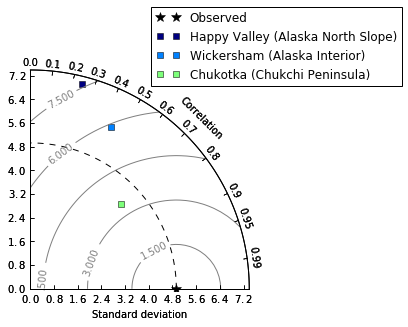

In [99]:
# compute reference standard deviation
refstds = []
for key, item in obs.items(): 
    refstds.append(np.std(item, ddof=1))

# compute stddev and correlation coefficient of models
samples = np.array([[item.std(ddof=1), np.corrcoef(obs[key], item)[0,1]] 
                    for key, item in sim.items()])

fig = plt.figure(figsize=(10, 4))

# ax1 = fig.add_subplot(1,2,1, xlabel='X', ylabel='Y')

####################################################################################################
# average refstd
alaska_avg_refstd = np.sum(refstds[2:5]) / 3.0 
avg_refstd = 11.0

# Taylor diagram
dia = TaylorDiagram(alaska_avg_refstd, fig=fig, rect=122, label='Reference')

colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(samples)))

# skip ax1 plotting stuff because I just want the Taylor diagram

# key_list = ['Barrow', 'toolik', 'happy_valley', 'wickersham', 'chukotka']
key_list = ['Happy Valley (Alaska North Slope)', 'Wickersham (Alaska Interior)', 'Chukotka (Chukchi Peninsula)']

# add samples to Taylor diagram 
for i, (stddev, corrcoef) in enumerate(samples[2:5]):
    dia.add_sample(stddev, corrcoef, marker='s', ls='', c=colors[i], label=key_list[i])
    
# add RMS contours and label them
contours = dia.add_contours(colors='0.5')
plt.clabel(contours, inline=1, fontsize=10)
plt.legend(bbox_to_anchor=(1.7, 1.3))

####################################################################################################

plotname = 'taylor_calm.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

Reference std:
Reference std:
Reference std:


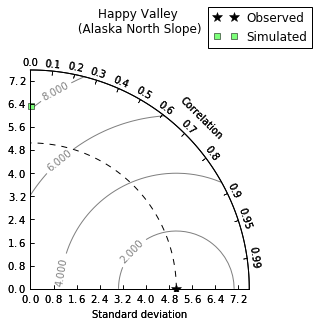

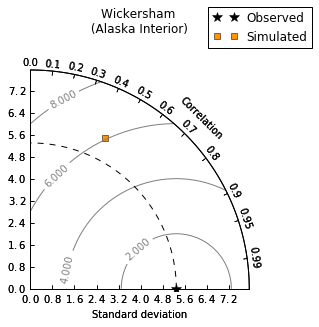

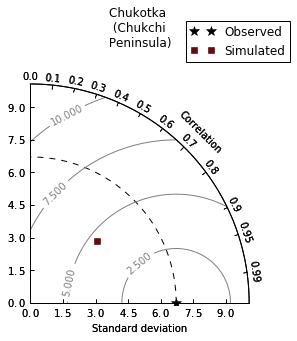

In [98]:
fig = plt.figure(figsize=(10, 4))

colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(samples)))

# Taylor diagram
dia = TaylorDiagram(refstds[1], fig=fig, rect=122, label='Reference')

# add samples to Taylor diagram 
for i, (stddev, corrcoef) in enumerate(samples[1:2]):
    dia.add_sample(stddev, corrcoef, marker='s', ls='', c=colors[2], label='Simulated')
    
# add RMS contours and label them
contours = dia.add_contours(colors='0.5')
plt.clabel(contours, inline=1, fontsize=10)
plt.title('Happy Valley \n (Alaska North Slope) \n \n')
plt.legend(bbox_to_anchor=(1.3, 1.3))

plotname = 'taylor_happyvalley.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

####################################
fig = plt.figure(figsize=(10, 4))

# Taylor diagram
dia = TaylorDiagram(refstds[3], fig=fig, rect=122, label='Reference')

# add samples to Taylor diagram 
for i, (stddev, corrcoef) in enumerate(samples[3:4]):
    dia.add_sample(stddev, corrcoef, marker='s', ls='', c=colors[3], label='Simulated')
    
# add RMS contours and label them
contours = dia.add_contours(colors='0.5')
plt.clabel(contours, inline=1, fontsize=10)
plt.title('Wickersham \n (Alaska Interior) \n \n')
plt.legend(bbox_to_anchor=(1.3, 1.3))

plotname = 'taylor_wickersham.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

#######################################

fig = plt.figure(figsize=(10, 4))

# Taylor diagram
dia = TaylorDiagram(refstds[4], fig=fig, rect=122, label='Reference')

# add samples to Taylor diagram 
for i, (stddev, corrcoef) in enumerate(samples[4:5]):
    dia.add_sample(stddev, corrcoef, marker='s', ls='', c=colors[4], label='Simulated')
    
# add RMS contours and label them
contours = dia.add_contours(colors='0.5')
plt.clabel(contours, inline=1, fontsize=10)
plt.title('Chukotka \n (Chukchi \n Peninsula) \n \n')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plotname = 'taylor_chukotka.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')